In [28]:
import pandas as pd
import numpy as np
from enum import Enum
import chess
from pathlib import Path
from typing import Tuple
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [29]:
if torch.cuda.is_available():
    device = "cuda" 
    print("CUDA version:", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name())
else:
    device = "cpu"
    
device

CUDA version: 12.9
GPU: NVIDIA GeForce RTX 3070


'cuda'

In [30]:
class NPZChessDataset(Dataset):
    def __init__(self, npz_path: Path):
        with np.load(npz_path) as data:
            self.X = torch.tensor(data["X"], dtype=torch.float32) # float32 for NNs
            self.y = torch.tensor(data["y"], dtype=torch.long) # long for CrossEntropyLoss

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        return self.X[idx], self.y[idx]

In [31]:
BATCH_SIZE = 2048
num_workers = 0

train_dataloader = DataLoader(dataset=NPZChessDataset("./dataset_processed/chess_bitboard_train.npz"), 
                              batch_size=BATCH_SIZE, 
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory=True)
val_dataloader = DataLoader(dataset=NPZChessDataset("./dataset_processed/chess_bitboard_val.npz"), 
                            batch_size=BATCH_SIZE, 
                            num_workers=num_workers,
                            shuffle=False,
                            pin_memory=True)
test_dataloader = DataLoader(dataset=NPZChessDataset("./dataset_processed/chess_bitboard_test.npz"), 
                             batch_size=BATCH_SIZE, 
                             num_workers=num_workers,
                             shuffle=False,
                             pin_memory=True)

In [32]:
import time

start = time.time()
for i, (X, y) in enumerate(train_dataloader):
    if i == 100:  # measure 100 batches
        break
print("Avg batch load time:", (time.time() - start) / 100)


Avg batch load time: 0.016196703910827635


In [33]:
Xb, yb = next(iter(train_dataloader))
print("X batch shape:", Xb.shape, "dtype:", Xb.dtype)
print("y batch shape:", yb.shape, "dtype:", yb.dtype, "classes in batch:", yb.unique().tolist())

X batch shape: torch.Size([2048, 768]) dtype: torch.float32
y batch shape: torch.Size([2048]) dtype: torch.int64 classes in batch: [0, 1, 2, 3, 4, 5, 6]


In [34]:
class PositionLabel(Enum):
    WHITE_WINNING = 0
    WHITE_DECISIVE = 1
    WHITE_BETTER = 2
    EQUAL = 3
    BLACK_BETTER = 4
    BLACK_DECISIVE = 5
    BLACK_WINNING = 6

In [35]:
class GiraffeBaseline(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        return self.network(x)

In [36]:
from torchinfo import summary

model = GiraffeBaseline(input_shape=768,
                        hidden_units=2048,
                        output_shape=7) # 7 classes

summary(model, input_size=(32, 768))

Layer (type:depth-idx)                   Output Shape              Param #
GiraffeBaseline                          [32, 7]                   --
├─Sequential: 1-1                        [32, 7]                   --
│    └─Linear: 2-1                       [32, 2048]                1,574,912
│    └─ReLU: 2-2                         [32, 2048]                --
│    └─Linear: 2-3                       [32, 2048]                4,196,352
│    └─ReLU: 2-4                         [32, 2048]                --
│    └─Linear: 2-5                       [32, 7]                   14,343
Total params: 5,785,607
Trainable params: 5,785,607
Non-trainable params: 0
Total mult-adds (M): 185.14
Input size (MB): 0.10
Forward/backward pass size (MB): 1.05
Params size (MB): 23.14
Estimated Total Size (MB): 24.29

In [37]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device) -> tuple[float, float]:
    """
    Performs one training epoch for the given model.
    Returns the average loss and accuracy across all batches.
    """
    
    # Put model in train mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # X and Y are both shape (BATCH_SIZE,)

        # Reset gradients
        optimizer.zero_grad()

        # Forward Pass
        y_pred = model(X)

        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        # Calculate accuracy metrics
        """softmax and argmax dim=1 because tensor of shape (batchsize, num_classes)"""
        y_pred_class = torch.argmax(y_pred, dim=-1) # y_pred_class.shape = (BATCH_SIZE,)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [38]:
def eval_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device) -> tuple[float, float]:
    """
    Evaluates the given model on the given dataloader without gradient updates.
    Dataloader should either be the validation or test dataloader.
    Returns the average loss and accuracy across all batches.
    """

    
    # Put model in eval mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Forward Pass
            test_pred = model(X)

            # Calculate the loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Calculate accuracy metrics
            test_pred_labels = torch.argmax(test_pred, dim=1)
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [39]:
from tqdm import tqdm
import copy

def run_experiment(model: torch.nn.Module,
                   train_dataloader: torch.utils.data.DataLoader,
                   val_dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   optimizer: torch.optim.Optimizer,
                   epochs: int,
                   device=device):
    
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []}
    
    best_val_loss = float("inf")
    best_model_weights = None
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        
        val_loss, val_acc = eval_step(model=model,
                                      dataloader=val_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            print(f"Epoch {epoch+1}: New Best Val Loss: {val_loss:.4f} (Saved)")
            torch.save(model.state_dict(), "best_giraffe_baseline.pth")
        else:
            print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

            
        print(f"Epoch: {epoch} | Train Loss: {train_loss} | Train Acc: {train_acc} | Val Loss: {val_loss} | Val Acc: {val_acc}")

        # To plot results later
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"\nLoaded best model weights with Val Loss: {best_val_loss:.4f}")

    return results

In [40]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = GiraffeBaseline(input_shape=768,
                        hidden_units=2048,
                        output_shape=7).to(device)

NUM_EPOCHS = 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

result = run_experiment(model=model,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        device=device)

  1%|          | 1/100 [00:11<19:04, 11.56s/it]

Epoch 1: New Best Val Loss: 0.7124 (Saved)
Epoch: 0 | Train Loss: 0.948549155536515 | Train Acc: 0.648996962915601 | Val Loss: 0.7123718699630426 | Val Acc: 0.7313642769902772


  2%|▏         | 2/100 [00:22<18:33, 11.36s/it]

Epoch 2: New Best Val Loss: 0.5636 (Saved)
Epoch: 1 | Train Loss: 0.555529955555411 | Train Acc: 0.7949016444213556 | Val Loss: 0.5635567295308016 | Val Acc: 0.7929773988015016


  3%|▎         | 3/100 [00:33<18:12, 11.26s/it]

Epoch 3: New Best Val Loss: 0.5169 (Saved)
Epoch: 2 | Train Loss: 0.38669861971264907 | Train Acc: 0.8593730019181586 | Val Loss: 0.5169008276900466 | Val Acc: 0.8186449734669812


  4%|▍         | 4/100 [00:44<17:24, 10.88s/it]

Epoch 4: New Best Val Loss: 0.5128 (Saved)
Epoch: 3 | Train Loss: 0.3022303254631779 | Train Acc: 0.8903630015185422 | Val Loss: 0.5128019245303407 | Val Acc: 0.8256407257773393


  5%|▌         | 5/100 [00:55<17:10, 10.85s/it]

Epoch 5: Train Loss: 0.2486 | Val Loss: 0.5175
Epoch: 4 | Train Loss: 0.24861725063427634 | Train Acc: 0.9096035306106138 | Val Loss: 0.5175015458038875 | Val Acc: 0.8337333717390257


  6%|▌         | 6/100 [01:05<16:54, 10.79s/it]

Epoch 6: Train Loss: 0.2087 | Val Loss: 0.5397
Epoch: 5 | Train Loss: 0.2086883116789791 | Train Acc: 0.9240032069213554 | Val Loss: 0.5397151021324859 | Val Acc: 0.8333351508350982


  7%|▋         | 7/100 [01:16<16:44, 10.80s/it]

Epoch 7: Train Loss: 0.1812 | Val Loss: 0.5533
Epoch: 6 | Train Loss: 0.18121225487850512 | Train Acc: 0.9340115988650894 | Val Loss: 0.5533003101543504 | Val Acc: 0.8364329259121102


  8%|▊         | 8/100 [01:27<16:32, 10.78s/it]

Epoch 8: Train Loss: 0.1574 | Val Loss: 0.5813
Epoch: 7 | Train Loss: 0.15740038479304375 | Train Acc: 0.9428723425511509 | Val Loss: 0.5812766235701892 | Val Acc: 0.8360578311513285


  9%|▉         | 9/100 [01:37<16:17, 10.74s/it]

Epoch 9: Train Loss: 0.1400 | Val Loss: 0.6098
Epoch: 8 | Train Loss: 0.1400187368435628 | Train Acc: 0.9488066456202046 | Val Loss: 0.6098046047346932 | Val Acc: 0.8387135772646322


 10%|█         | 10/100 [01:48<16:02, 10.70s/it]

Epoch 10: Train Loss: 0.1261 | Val Loss: 0.6606
Epoch: 9 | Train Loss: 0.12607027491187806 | Train Acc: 0.9541887288203326 | Val Loss: 0.6606107439313617 | Val Acc: 0.8381846842510589


 11%|█         | 11/100 [01:59<15:53, 10.72s/it]

Epoch 11: Train Loss: 0.1144 | Val Loss: 0.6623
Epoch: 10 | Train Loss: 0.11441005962660246 | Train Acc: 0.9585722706202046 | Val Loss: 0.6622825569036056 | Val Acc: 0.8403213142568348


 12%|█▏        | 12/100 [02:10<16:07, 10.99s/it]

Epoch 12: Train Loss: 0.1032 | Val Loss: 0.6915
Epoch: 11 | Train Loss: 0.10319708087636381 | Train Acc: 0.9628069553228901 | Val Loss: 0.6915454730695608 | Val Acc: 0.8393409914083558


 13%|█▎        | 13/100 [02:22<16:09, 11.14s/it]

Epoch 13: Train Loss: 0.0958 | Val Loss: 0.7082
Epoch: 12 | Train Loss: 0.09579894034301534 | Train Acc: 0.9657383911445013 | Val Loss: 0.7081625619713141 | Val Acc: 0.8412903560598768


 14%|█▍        | 14/100 [02:34<16:12, 11.31s/it]

Epoch 14: Train Loss: 0.0876 | Val Loss: 0.7394
Epoch: 13 | Train Loss: 0.08763875517889362 | Train Acc: 0.9687962056425832 | Val Loss: 0.7394439054995167 | Val Acc: 0.841029951927705


 15%|█▌        | 15/100 [02:45<15:59, 11.29s/it]

Epoch 15: Train Loss: 0.0809 | Val Loss: 0.7603
Epoch: 14 | Train Loss: 0.08090218225174853 | Train Acc: 0.9714296775095909 | Val Loss: 0.7602584033596272 | Val Acc: 0.8418662534294379


 16%|█▌        | 16/100 [02:56<15:48, 11.30s/it]

Epoch 16: Train Loss: 0.0756 | Val Loss: 0.7778
Epoch: 15 | Train Loss: 0.07563063615690106 | Train Acc: 0.9733490848785167 | Val Loss: 0.777824096533717 | Val Acc: 0.8398330330068348


 17%|█▋        | 17/100 [03:08<15:45, 11.40s/it]

Epoch 17: Train Loss: 0.0688 | Val Loss: 0.8074
Epoch: 16 | Train Loss: 0.06882264006816213 | Train Acc: 0.9758524316656011 | Val Loss: 0.8074138371311889 | Val Acc: 0.8405587802632846


 18%|█▊        | 18/100 [03:19<15:29, 11.33s/it]

Epoch 18: Train Loss: 0.0662 | Val Loss: 0.8200
Epoch: 17 | Train Loss: 0.06618231458737113 | Train Acc: 0.9769706082161126 | Val Loss: 0.8200228481876607 | Val Acc: 0.842937388693685


 19%|█▉        | 19/100 [03:31<15:28, 11.47s/it]

Epoch 19: Train Loss: 0.0619 | Val Loss: 0.8409
Epoch: 18 | Train Loss: 0.061919294821712975 | Train Acc: 0.9785038862691816 | Val Loss: 0.8408579327622239 | Val Acc: 0.8423989067914902


 20%|██        | 20/100 [03:43<15:27, 11.60s/it]

Epoch 20: Train Loss: 0.0578 | Val Loss: 0.8432
Epoch: 19 | Train Loss: 0.05782928951370442 | Train Acc: 0.9802294796994885 | Val Loss: 0.8432010813635222 | Val Acc: 0.8432425409727571


 21%|██        | 21/100 [03:54<15:15, 11.59s/it]

Epoch 21: Train Loss: 0.0545 | Val Loss: 0.8669
Epoch: 20 | Train Loss: 0.0544675709131886 | Train Acc: 0.9813219309462915 | Val Loss: 0.8669452083354093 | Val Acc: 0.8424628327156335


 22%|██▏       | 22/100 [04:06<15:04, 11.59s/it]

Epoch 22: Train Loss: 0.0516 | Val Loss: 0.8872
Epoch: 21 | Train Loss: 0.05157872899185361 | Train Acc: 0.9826588974584399 | Val Loss: 0.8871584060240765 | Val Acc: 0.8435685631858876


 23%|██▎       | 23/100 [04:17<14:39, 11.42s/it]

Epoch 23: Train Loss: 0.0489 | Val Loss: 0.9055
Epoch: 22 | Train Loss: 0.048898675609999304 | Train Acc: 0.9837505994245525 | Val Loss: 0.9054623331342425 | Val Acc: 0.8407477377743551


 24%|██▍       | 24/100 [04:28<14:22, 11.35s/it]

Epoch 24: Train Loss: 0.0466 | Val Loss: 0.9126
Epoch: 23 | Train Loss: 0.04656821304498731 | Train Acc: 0.9843887368126598 | Val Loss: 0.9126085602507299 | Val Acc: 0.8418521521226415


 25%|██▌       | 25/100 [04:39<14:09, 11.32s/it]

Epoch 25: Train Loss: 0.0451 | Val Loss: 0.9539
Epoch: 24 | Train Loss: 0.045085229656046916 | Train Acc: 0.985060092311381 | Val Loss: 0.9538611879154127 | Val Acc: 0.8419251028831344


 26%|██▌       | 26/100 [04:51<14:01, 11.37s/it]

Epoch 26: Train Loss: 0.0434 | Val Loss: 0.9429
Epoch: 25 | Train Loss: 0.043435586783129844 | Train Acc: 0.9857669137627877 | Val Loss: 0.942925728097254 | Val Acc: 0.8448948380944359


 27%|██▋       | 27/100 [05:02<13:45, 11.30s/it]

Epoch 27: Train Loss: 0.0406 | Val Loss: 0.9589
Epoch: 26 | Train Loss: 0.04055444665176942 | Train Acc: 0.9868940816815857 | Val Loss: 0.9589453132785096 | Val Acc: 0.8438833043535812


 28%|██▊       | 28/100 [05:13<13:32, 11.28s/it]

Epoch 28: Train Loss: 0.0390 | Val Loss: 0.9753
Epoch: 27 | Train Loss: 0.039011026277680834 | Train Acc: 0.9873656289961638 | Val Loss: 0.9752685987219518 | Val Acc: 0.8445018816783788


 29%|██▉       | 29/100 [05:24<13:20, 11.28s/it]

Epoch 29: Train Loss: 0.0373 | Val Loss: 0.9849
Epoch: 28 | Train Loss: 0.037332699481693224 | Train Acc: 0.9881588674872123 | Val Loss: 0.9848876376541293 | Val Acc: 0.8441455886599922


 30%|███       | 30/100 [05:36<13:09, 11.28s/it]

Epoch 30: Train Loss: 0.0369 | Val Loss: 0.9741
Epoch: 29 | Train Loss: 0.036897333810472735 | Train Acc: 0.9882627677429667 | Val Loss: 0.9741313408832161 | Val Acc: 0.8438592381233154


 31%|███       | 31/100 [05:47<13:05, 11.38s/it]

Epoch 31: Train Loss: 0.0353 | Val Loss: 0.9797
Epoch: 30 | Train Loss: 0.035305048160426455 | Train Acc: 0.9888469569213555 | Val Loss: 0.9796508745271333 | Val Acc: 0.8434469159125915


 32%|███▏      | 32/100 [05:59<13:01, 11.49s/it]

Epoch 32: Train Loss: 0.0335 | Val Loss: 0.9985
Epoch: 31 | Train Loss: 0.033469887121635324 | Train Acc: 0.9894259011349105 | Val Loss: 0.9985131986287176 | Val Acc: 0.8457309515787448


 33%|███▎      | 33/100 [06:10<12:39, 11.34s/it]

Epoch 33: Train Loss: 0.0331 | Val Loss: 1.0014
Epoch: 32 | Train Loss: 0.033131411089502336 | Train Acc: 0.9896811560901535 | Val Loss: 1.0013638017128925 | Val Acc: 0.8469237341162881


 34%|███▍      | 34/100 [06:21<12:22, 11.24s/it]

Epoch 34: Train Loss: 0.0322 | Val Loss: 1.0262
Epoch: 33 | Train Loss: 0.03222291958530236 | Train Acc: 0.9898759690696931 | Val Loss: 1.0261582805185903 | Val Acc: 0.8460261389343473


 35%|███▌      | 35/100 [06:32<11:59, 11.08s/it]

Epoch 35: Train Loss: 0.0313 | Val Loss: 1.0345
Epoch: 34 | Train Loss: 0.031256355383359566 | Train Acc: 0.9903450187819692 | Val Loss: 1.0345226903350986 | Val Acc: 0.8449685409246246


 36%|███▌      | 36/100 [06:43<11:44, 11.01s/it]

Epoch 36: Train Loss: 0.0301 | Val Loss: 1.0208
Epoch: 35 | Train Loss: 0.030087518441440808 | Train Acc: 0.9907718590153453 | Val Loss: 1.020809459442995 | Val Acc: 0.8456860154144205


 37%|███▋      | 37/100 [06:53<11:30, 10.97s/it]

Epoch 37: Train Loss: 0.0293 | Val Loss: 1.0336
Epoch: 36 | Train Loss: 0.029272123006508326 | Train Acc: 0.9911435022378516 | Val Loss: 1.0336065158552052 | Val Acc: 0.8450849237100501


 38%|███▊      | 38/100 [07:04<11:13, 10.86s/it]

Epoch 38: Train Loss: 0.0276 | Val Loss: 1.0500
Epoch: 37 | Train Loss: 0.027618506313551724 | Train Acc: 0.9916380274936062 | Val Loss: 1.049988522821543 | Val Acc: 0.8466614498098768


 39%|███▉      | 39/100 [07:15<11:05, 10.91s/it]

Epoch 39: Train Loss: 0.0270 | Val Loss: 1.0444
Epoch: 38 | Train Loss: 0.02698207411514905 | Train Acc: 0.9918817934782608 | Val Loss: 1.0443916856026163 | Val Acc: 0.84628278271804


 40%|████      | 40/100 [07:26<10:55, 10.93s/it]

Epoch 40: Train Loss: 0.0271 | Val Loss: 1.0586
Epoch: 39 | Train Loss: 0.02711246387027871 | Train Acc: 0.9919299972026855 | Val Loss: 1.058625193274751 | Val Acc: 0.8465335979615902


 41%|████      | 41/100 [07:37<10:51, 11.04s/it]

Epoch 41: Train Loss: 0.0274 | Val Loss: 1.0799
Epoch: 40 | Train Loss: 0.027439988404036025 | Train Acc: 0.9919187579923274 | Val Loss: 1.0798529763610996 | Val Acc: 0.8465890631016558


 42%|████▏     | 42/100 [07:48<10:37, 10.98s/it]

Epoch 42: Train Loss: 0.0247 | Val Loss: 1.0764
Epoch: 41 | Train Loss: 0.024747311856950182 | Train Acc: 0.9926687879635551 | Val Loss: 1.0763948365133635 | Val Acc: 0.8464463578768772


 43%|████▎     | 43/100 [07:59<10:28, 11.03s/it]

Epoch 43: Train Loss: 0.0244 | Val Loss: 1.0883
Epoch: 42 | Train Loss: 0.02441802458680423 | Train Acc: 0.9927472126758311 | Val Loss: 1.0882592760786718 | Val Acc: 0.8476852046832885


 44%|████▍     | 44/100 [08:10<10:16, 11.01s/it]

Epoch 44: Train Loss: 0.0253 | Val Loss: 1.0790
Epoch: 43 | Train Loss: 0.025287403239180214 | Train Acc: 0.9926240808823529 | Val Loss: 1.079044135249391 | Val Acc: 0.8462810905612245


 45%|████▌     | 45/100 [08:21<10:02, 10.96s/it]

Epoch 45: Train Loss: 0.0232 | Val Loss: 1.0793
Epoch: 44 | Train Loss: 0.02321903058625472 | Train Acc: 0.9932652153932225 | Val Loss: 1.079348207736502 | Val Acc: 0.8461536147477858


 46%|████▌     | 46/100 [08:32<09:53, 10.98s/it]

Epoch 46: Train Loss: 0.0233 | Val Loss: 1.1254
Epoch: 45 | Train Loss: 0.0232838301936074 | Train Acc: 0.9932911904571612 | Val Loss: 1.1254409502963632 | Val Acc: 0.8477102110006739


 47%|████▋     | 47/100 [08:43<09:41, 10.98s/it]

Epoch 47: Train Loss: 0.0230 | Val Loss: 1.1011
Epoch: 46 | Train Loss: 0.02299010707184558 | Train Acc: 0.9933139186381074 | Val Loss: 1.1010579624954535 | Val Acc: 0.8469902922843665


 48%|████▊     | 48/100 [08:54<09:30, 10.98s/it]

Epoch 48: Train Loss: 0.0230 | Val Loss: 1.0720
Epoch: 47 | Train Loss: 0.02295509229183121 | Train Acc: 0.9934108256074169 | Val Loss: 1.0719923936590856 | Val Acc: 0.8468880108057375


 49%|████▉     | 49/100 [09:05<09:20, 10.98s/it]

Epoch 49: Train Loss: 0.0223 | Val Loss: 1.0819
Epoch: 48 | Train Loss: 0.022340742320946568 | Train Acc: 0.9935689238331201 | Val Loss: 1.0819053151169602 | Val Acc: 0.8468205125505391


 50%|█████     | 50/100 [09:16<09:13, 11.06s/it]

Epoch 50: Train Loss: 0.0207 | Val Loss: 1.1301
Epoch: 49 | Train Loss: 0.02074462050915031 | Train Acc: 0.9939612971547315 | Val Loss: 1.130149067664633 | Val Acc: 0.846538486414613


 51%|█████     | 51/100 [09:27<08:57, 10.96s/it]

Epoch 51: Train Loss: 0.0215 | Val Loss: 1.1053
Epoch: 50 | Train Loss: 0.021483367691269083 | Train Acc: 0.993830922314578 | Val Loss: 1.1052918251679869 | Val Acc: 0.8463342994922025


 52%|█████▏    | 52/100 [09:38<08:41, 10.87s/it]

Epoch 52: Train Loss: 0.0205 | Val Loss: 1.0896
Epoch: 51 | Train Loss: 0.02048775651599364 | Train Acc: 0.9941571091751917 | Val Loss: 1.0895771651851887 | Val Acc: 0.8471251007773393


 53%|█████▎    | 53/100 [09:49<08:36, 10.99s/it]

Epoch 53: Train Loss: 0.0198 | Val Loss: 1.1222
Epoch: 52 | Train Loss: 0.019833251043125187 | Train Acc: 0.9943114609974425 | Val Loss: 1.12223012836612 | Val Acc: 0.8477810935695033


 54%|█████▍    | 54/100 [10:00<08:19, 10.86s/it]

Epoch 54: Train Loss: 0.0202 | Val Loss: 1.1321
Epoch: 53 | Train Loss: 0.020249206563243475 | Train Acc: 0.9941091552109975 | Val Loss: 1.132090109951642 | Val Acc: 0.8476068014175009


 55%|█████▌    | 55/100 [10:11<08:09, 10.89s/it]

Epoch 55: Train Loss: 0.0197 | Val Loss: 1.1330
Epoch: 54 | Train Loss: 0.019716449446328308 | Train Acc: 0.9943062160326087 | Val Loss: 1.1329719326934036 | Val Acc: 0.8482453085892375


 56%|█████▌    | 56/100 [10:21<07:48, 10.65s/it]

Epoch 56: Train Loss: 0.0193 | Val Loss: 1.1434
Epoch: 55 | Train Loss: 0.01934798389954297 | Train Acc: 0.9944892902813298 | Val Loss: 1.1433971682373358 | Val Acc: 0.848602541694744


 57%|█████▋    | 57/100 [10:30<07:27, 10.41s/it]

Epoch 57: Train Loss: 0.0192 | Val Loss: 1.1587
Epoch: 56 | Train Loss: 0.019231381652224093 | Train Acc: 0.9945347466432225 | Val Loss: 1.158689716640784 | Val Acc: 0.8482097732961109


 58%|█████▊    | 58/100 [10:41<07:13, 10.33s/it]

Epoch 58: Train Loss: 0.0183 | Val Loss: 1.1322
Epoch: 57 | Train Loss: 0.018303740841081686 | Train Acc: 0.9948332101182864 | Val Loss: 1.132188738608847 | Val Acc: 0.8480950826675009


 59%|█████▉    | 59/100 [10:51<06:58, 10.20s/it]

Epoch 59: Train Loss: 0.0176 | Val Loss: 1.1645
Epoch: 58 | Train Loss: 0.0175548486990373 | Train Acc: 0.9950787244245524 | Val Loss: 1.1645395098900309 | Val Acc: 0.848873286785233


 60%|██████    | 60/100 [11:01<06:49, 10.23s/it]

Epoch 60: Train Loss: 0.0171 | Val Loss: 1.1634
Epoch: 59 | Train Loss: 0.017056240389347457 | Train Acc: 0.9952443154571612 | Val Loss: 1.1634476245666037 | Val Acc: 0.8482088332089911


 61%|██████    | 61/100 [11:11<06:33, 10.10s/it]

Epoch 61: Train Loss: 0.0171 | Val Loss: 1.1585
Epoch: 60 | Train Loss: 0.01708009399954811 | Train Acc: 0.9953005115089515 | Val Loss: 1.1585384278881306 | Val Acc: 0.8483225837504813


 62%|██████▏   | 62/100 [11:21<06:29, 10.25s/it]

Epoch 62: Train Loss: 0.0173 | Val Loss: 1.1786
Epoch: 61 | Train Loss: 0.017346681587521912 | Train Acc: 0.9950899636349104 | Val Loss: 1.1785582717584104 | Val Acc: 0.8494881037615518


 63%|██████▎   | 63/100 [11:32<06:27, 10.47s/it]

Epoch 63: Train Loss: 0.0185 | Val Loss: 1.1566
Epoch: 62 | Train Loss: 0.018513503867913696 | Train Acc: 0.9948317115569054 | Val Loss: 1.156554979937417 | Val Acc: 0.8485160536797266


 64%|██████▍   | 64/100 [11:44<06:28, 10.79s/it]

Epoch 64: Train Loss: 0.0169 | Val Loss: 1.1475
Epoch: 63 | Train Loss: 0.01692243567441621 | Train Acc: 0.9953299832161125 | Val Loss: 1.1474745224933236 | Val Acc: 0.8476246630727763


 65%|██████▌   | 65/100 [11:55<06:25, 11.01s/it]

Epoch 65: Train Loss: 0.0162 | Val Loss: 1.1629
Epoch: 64 | Train Loss: 0.01620558706348014 | Train Acc: 0.9956296954923274 | Val Loss: 1.162910354380705 | Val Acc: 0.8482528292861956


 66%|██████▌   | 66/100 [12:05<06:04, 10.73s/it]

Epoch 66: Train Loss: 0.0164 | Val Loss: 1.1694
Epoch: 65 | Train Loss: 0.01643760072226967 | Train Acc: 0.995576246803069 | Val Loss: 1.1693642321898012 | Val Acc: 0.8493854462480747


 67%|██████▋   | 67/100 [12:15<05:45, 10.48s/it]

Epoch 67: Train Loss: 0.0153 | Val Loss: 1.1768
Epoch: 66 | Train Loss: 0.01525042086834912 | Train Acc: 0.9958549792199489 | Val Loss: 1.1767690400688016 | Val Acc: 0.848010850861571


 68%|██████▊   | 68/100 [12:25<05:30, 10.32s/it]

Epoch 68: Train Loss: 0.0160 | Val Loss: 1.1865
Epoch: 67 | Train Loss: 0.01602384678619292 | Train Acc: 0.9955645080722506 | Val Loss: 1.1864895285392294 | Val Acc: 0.847816816880054


 69%|██████▉   | 69/100 [12:35<05:16, 10.20s/it]

Epoch 69: Train Loss: 0.0162 | Val Loss: 1.1841
Epoch: 68 | Train Loss: 0.016158661590722365 | Train Acc: 0.9955662563938619 | Val Loss: 1.1841135073681266 | Val Acc: 0.8494200414540817


 70%|███████   | 70/100 [12:45<05:04, 10.15s/it]

Epoch 70: Train Loss: 0.0150 | Val Loss: 1.1914
Epoch: 69 | Train Loss: 0.014967583131183253 | Train Acc: 0.9958991867806904 | Val Loss: 1.1914280823298864 | Val Acc: 0.8497434314232768


 71%|███████   | 71/100 [12:55<04:50, 10.01s/it]

Epoch 71: Train Loss: 0.0148 | Val Loss: 1.1999
Epoch: 70 | Train Loss: 0.014774324090751198 | Train Acc: 0.9960133272058823 | Val Loss: 1.1999183126858302 | Val Acc: 0.8502258841331344


 72%|███████▏  | 72/100 [13:05<04:39,  9.99s/it]

Epoch 72: Train Loss: 0.0158 | Val Loss: 1.2169
Epoch: 71 | Train Loss: 0.01575259353293825 | Train Acc: 0.9956651614450128 | Val Loss: 1.2169494458607264 | Val Acc: 0.846195542633327


 73%|███████▎  | 73/100 [13:15<04:28,  9.95s/it]

Epoch 73: Train Loss: 0.0153 | Val Loss: 1.2222
Epoch: 72 | Train Loss: 0.015287252320476886 | Train Acc: 0.9958842011668797 | Val Loss: 1.2222143387307927 | Val Acc: 0.8494341427608779


 74%|███████▍  | 74/100 [13:25<04:19,  9.98s/it]

Epoch 74: Train Loss: 0.0156 | Val Loss: 1.2213
Epoch: 73 | Train Loss: 0.01561998730272893 | Train Acc: 0.9956419337436061 | Val Loss: 1.2212609405420265 | Val Acc: 0.8499098268434732


 75%|███████▌  | 75/100 [13:35<04:10, 10.03s/it]

Epoch 75: Train Loss: 0.0148 | Val Loss: 1.2311
Epoch: 74 | Train Loss: 0.01480476883575892 | Train Acc: 0.9961569393382352 | Val Loss: 1.2310580745035289 | Val Acc: 0.849540748640258


 76%|███████▌  | 76/100 [13:45<04:02, 10.11s/it]

Epoch 76: Train Loss: 0.0139 | Val Loss: 1.2279
Epoch: 75 | Train Loss: 0.013930944163742883 | Train Acc: 0.9962256234015345 | Val Loss: 1.2278988872255598 | Val Acc: 0.8505966544931652


 77%|███████▋  | 77/100 [13:55<03:53, 10.14s/it]

Epoch 77: Train Loss: 0.0137 | Val Loss: 1.2112
Epoch: 76 | Train Loss: 0.013737024102822099 | Train Acc: 0.9963290241368287 | Val Loss: 1.2112162526772947 | Val Acc: 0.8495768479856565


 78%|███████▊  | 78/100 [14:05<03:42, 10.10s/it]

Epoch 78: Train Loss: 0.0134 | Val Loss: 1.2517
Epoch: 77 | Train Loss: 0.013428150362375638 | Train Acc: 0.9963390145460358 | Val Loss: 1.2517060382025582 | Val Acc: 0.8498692150798999


 79%|███████▉  | 79/100 [14:16<03:32, 10.12s/it]

Epoch 79: Train Loss: 0.0134 | Val Loss: 1.2241
Epoch: 78 | Train Loss: 0.013391485568159795 | Train Acc: 0.9963757292998722 | Val Loss: 1.2240551028932845 | Val Acc: 0.8506485473021755


 80%|████████  | 80/100 [14:26<03:23, 10.17s/it]

Epoch 80: Train Loss: 0.0133 | Val Loss: 1.2173
Epoch: 79 | Train Loss: 0.013281344485533473 | Train Acc: 0.9964406669597188 | Val Loss: 1.2172860904615752 | Val Acc: 0.8486991826506546


 81%|████████  | 81/100 [14:36<03:13, 10.19s/it]

Epoch 81: Train Loss: 0.0142 | Val Loss: 1.2128
Epoch: 80 | Train Loss: 0.014167950557702032 | Train Acc: 0.9962278712436061 | Val Loss: 1.2127903043007364 | Val Acc: 0.8493029065989603


 82%|████████▏ | 82/100 [14:46<03:03, 10.20s/it]

Epoch 82: Train Loss: 0.0136 | Val Loss: 1.2359
Epoch: 81 | Train Loss: 0.013578857339875738 | Train Acc: 0.9963295236572891 | Val Loss: 1.2359492194895842 | Val Acc: 0.8498754196548902


 83%|████████▎ | 83/100 [14:56<02:52, 10.14s/it]

Epoch 83: Train Loss: 0.0135 | Val Loss: 1.2479
Epoch: 82 | Train Loss: 0.013464647994312408 | Train Acc: 0.9962910605818415 | Val Loss: 1.2478745762182741 | Val Acc: 0.8496097510348478


 84%|████████▍ | 84/100 [15:06<02:41, 10.07s/it]

Epoch 84: Train Loss: 0.0125 | Val Loss: 1.2305
Epoch: 83 | Train Loss: 0.01253671159901087 | Train Acc: 0.9965538083439898 | Val Loss: 1.2304756787358497 | Val Acc: 0.8500299699773777


 85%|████████▌ | 85/100 [15:16<02:29,  9.96s/it]

Epoch 85: Train Loss: 0.0134 | Val Loss: 1.2438
Epoch: 84 | Train Loss: 0.013392432663075226 | Train Acc: 0.9964653932225064 | Val Loss: 1.2437721296232573 | Val Acc: 0.8510886960916442


 86%|████████▌ | 86/100 [15:26<02:20, 10.01s/it]

Epoch 86: Train Loss: 0.0128 | Val Loss: 1.2663
Epoch: 85 | Train Loss: 0.012792531935655323 | Train Acc: 0.9965755374840154 | Val Loss: 1.2663068917332863 | Val Acc: 0.8502458139800732


 87%|████████▋ | 87/100 [15:36<02:10, 10.07s/it]

Epoch 87: Train Loss: 0.0114 | Val Loss: 1.2413
Epoch: 86 | Train Loss: 0.011420005542414307 | Train Acc: 0.9970123681265984 | Val Loss: 1.2412777092992042 | Val Acc: 0.8507643660353292


 88%|████████▊ | 88/100 [15:46<02:00, 10.04s/it]

Epoch 88: Train Loss: 0.0110 | Val Loss: 1.2473
Epoch: 87 | Train Loss: 0.01099858153909159 | Train Acc: 0.9971729639546035 | Val Loss: 1.2473054345773191 | Val Acc: 0.8514498775630535


 89%|████████▉ | 89/100 [15:56<01:50, 10.02s/it]

Epoch 89: Train Loss: 0.0115 | Val Loss: 1.2354
Epoch: 88 | Train Loss: 0.0114863002589425 | Train Acc: 0.9969951346707162 | Val Loss: 1.2353871099802913 | Val Acc: 0.849883692421544


 90%|█████████ | 90/100 [16:07<01:41, 10.15s/it]

Epoch 90: Train Loss: 0.0136 | Val Loss: 1.2447
Epoch: 89 | Train Loss: 0.013592893319666538 | Train Acc: 0.996397957960358 | Val Loss: 1.2446848397352257 | Val Acc: 0.8492713196717366


 91%|█████████ | 91/100 [16:17<01:31, 10.16s/it]

Epoch 91: Train Loss: 0.0133 | Val Loss: 1.2449
Epoch: 90 | Train Loss: 0.013316418995242328 | Train Acc: 0.9963949608375958 | Val Loss: 1.2448862377478151 | Val Acc: 0.8498682749927801


 92%|█████████▏| 92/100 [16:27<01:21, 10.16s/it]

Epoch 92: Train Loss: 0.0131 | Val Loss: 1.2366
Epoch: 91 | Train Loss: 0.013133980900101611 | Train Acc: 0.9966187460038364 | Val Loss: 1.236624493890879 | Val Acc: 0.8509034989290527


 93%|█████████▎| 93/100 [16:37<01:10, 10.08s/it]

Epoch 93: Train Loss: 0.0118 | Val Loss: 1.2623
Epoch: 92 | Train Loss: 0.0118442520414672 | Train Acc: 0.9969087176310741 | Val Loss: 1.2622879865218182 | Val Acc: 0.8502080224778591


 94%|█████████▍| 94/100 [16:47<01:00, 10.13s/it]

Epoch 94: Train Loss: 0.0105 | Val Loss: 1.2930
Epoch: 93 | Train Loss: 0.01046788295173584 | Train Acc: 0.9972461437020461 | Val Loss: 1.2930068385844329 | Val Acc: 0.8503063555905853


 95%|█████████▌| 95/100 [16:57<00:50, 10.05s/it]

Epoch 95: Train Loss: 0.0105 | Val Loss: 1.2537
Epoch: 94 | Train Loss: 0.010489420668171991 | Train Acc: 0.9972369025735295 | Val Loss: 1.2536660481472404 | Val Acc: 0.8507715106974393


 96%|█████████▌| 96/100 [17:07<00:40, 10.07s/it]

Epoch 96: Train Loss: 0.0122 | Val Loss: 1.2464
Epoch: 95 | Train Loss: 0.012178028873560945 | Train Acc: 0.9968402833280052 | Val Loss: 1.2463722593930302 | Val Acc: 0.8504547013380824


 97%|█████████▋| 97/100 [17:18<00:30, 10.27s/it]

Epoch 97: Train Loss: 0.0120 | Val Loss: 1.2489
Epoch: 96 | Train Loss: 0.011970427644717724 | Train Acc: 0.9969189578005115 | Val Loss: 1.248885298261837 | Val Acc: 0.8502104667043705


 98%|█████████▊| 98/100 [17:28<00:20, 10.32s/it]

Epoch 98: Train Loss: 0.0109 | Val Loss: 1.2612
Epoch: 97 | Train Loss: 0.010873387201481958 | Train Acc: 0.9971494864929668 | Val Loss: 1.2612167596817017 | Val Acc: 0.84983067150799


 99%|█████████▉| 99/100 [17:38<00:10, 10.26s/it]

Epoch 99: Train Loss: 0.0105 | Val Loss: 1.2707
Epoch: 98 | Train Loss: 0.010504986349459918 | Train Acc: 0.997208429907289 | Val Loss: 1.270700345233995 | Val Acc: 0.8522780943155563


100%|██████████| 100/100 [17:49<00:00, 10.69s/it]

Epoch 100: Train Loss: 0.0111 | Val Loss: 1.2668
Epoch: 99 | Train Loss: 0.011137737916982578 | Train Acc: 0.9970803029092071 | Val Loss: 1.2668180125100272 | Val Acc: 0.8514196067577975

Loaded best model weights with Val Loss: 0.5128


In [41]:
piece_to_index = {"P":0,
                  "N":1,
                  "B":2,
                  "R":3,
                  "Q":4,
                  "K":5,
                  "p":6,
                  "n":7,
                  "b":8,
                  "r":9,
                  "q":10,
                  "k":11}

In [42]:
def fen_to_vector(fen: str) -> np.ndarray:
    """
    Convert a FEN string into a 768-length binary vector.
    Each of the 12 piece types has its own 64-slot block, one per square. 
    A 1 marks the presence of a piece on a square, 0 otherwise.
    """

    board = chess.Board(fen)
    vector = np.zeros(64*12, dtype=np.uint8)

    for square, piece in board.piece_map().items():
        idx = 64*piece_to_index[piece.symbol()] + square
        vector[idx] = 1
    return vector

Model Prediction:  5
Stockfish Evaluation:  5


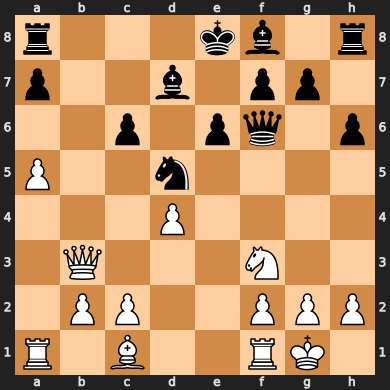

In [54]:
def check_model_prediction(model: torch.nn.Module,
                           random_fen: str,
                           fen_class: int,
                           device=device):
    """Takes the given fen to see the board, predicted score and actual score"""

    numpy_fen = fen_to_vector(random_fen)
    torch_fen = torch.tensor(numpy_fen, dtype=torch.float32).unsqueeze(0).to(device)
    pred = torch.argmax(model(torch_fen), dim=-1)
    print("Model Prediction: ", pred.item())
    print("Stockfish Evaluation: ", fen_class)

# Remember to update fen_class manually
random_fen = "r3kb1r/p2b1pp1/2p1pq1p/P2n4/3P4/1Q3N2/1PP2PPP/R1B2RK1 b kq - 2 14"
check_model_prediction(model=model,
                       random_fen=random_fen,
                       fen_class=5, # remember to manually set 
                       device=device)

board = chess.Board(random_fen)
board

In [ ]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.inference_mode():
    for X, y in val_dataloader:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.85      0.73      0.78      5103
           1       0.67      0.74      0.70      7064
           2       0.72      0.67      0.69     14354
           3       0.88      0.93      0.90     57672
           4       0.75      0.62      0.67      7618
           5       0.69      0.71      0.70      4718
           6       0.85      0.73      0.79      3471

    accuracy                           0.83    100000
   macro avg       0.77      0.73      0.75    100000
weighted avg       0.82      0.83      0.82    100000



In [ ]:
import json
import time

def save_config_metadata(experiment_name: str, 
                         model: torch.nn.Module, 
                         hyperparams: dict, 
                         dataset_paths: dict,
                         save_dir: str = "experiments/logs"):
    """
    Saves all 'static' setup details: Model architecture, parameter counts, 
    datasets used, and hyperparameters.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    # Model Metadata
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    config_data = {
        "experiment_name": experiment_name,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "model_architecture": {
            "class_name": model.__class__.__name__,
            "total_parameters": total_params,
            "trainable_parameters": trainable_params,
            "input_dim": hyperparams.get("input_shape", "unknown"),
            "output_dim": hyperparams.get("output_shape", "unknown"),
            "structure_summary": str(model)
        },
        "datasets": dataset_paths,
        "hyperparameters": hyperparams,
        "device": torch.cuda.get_device_name() if torch.cuda.is_available() else "cpu"
    }

    file_path = f"{save_dir}/{experiment_name}_config.json"
    with open(file_path, "w") as f:
        json.dump(config_data, f, indent=4)
    
    print(f"[Config] Saved metadata to {file_path}")


In [61]:
def save_training_logs(experiment_name: str, 
                       results_dict: dict, 
                       save_dir: str = "experiments/logs"):
    """
    Saves the epoch-by-epoch learning curves (Loss/Acc) to CSV.
    Expects results_dict to be the output from your run_experiment function.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    df = pd.DataFrame(results_dict)
    
    if "epoch" not in df.columns:
        df["epoch"] = range(1, len(df) + 1)
        
    file_path = f"{save_dir}/{experiment_name}_learning_curves.csv"
    df.to_csv(file_path, index=False)
    
    print(f"[Logs] Saved training history to {file_path}")

In [62]:
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from typing import List, Dict, Tuple

def calculate_ordinal_metrics(preds: np.ndarray,
                              labels: np.ndarray) -> Dict[str, float]:
    """
    Calculates metrics specific to ordinal classification (where Class 0 is close to Class 1).
    """
    abs_diffs = np.abs(preds - labels)
    
    metrics = {
        "mae": float(np.mean(abs_diffs)),
        "off_by_one_accuracy": float(np.mean(abs_diffs <= 1)),
        "off_by_two_accuracy": float(np.mean(abs_diffs <= 2))
    }
    return metrics

def categorize_failures(preds: np.ndarray, 
                        labels: np.ndarray) -> Dict[int, List[int]]:
    """
    Categorizes errors by magnitude.
    Returns a dict where keys are the error magnitude (3, 4, 5, 6) and values are lists of dataset indices.
    """
    abs_diffs = np.abs(preds - labels)
    failure_dict = {}
    
    # We care about errors >= 3 (e.g. Predicting 'Equal' when 'Black Winning')
    # Max error is 6 (Predicting 'White Winning' when 'Black Winning')
    for magnitude in range(3, 7):
        indices = np.where(abs_diffs == magnitude)[0].tolist()
        if indices:
            failure_dict[magnitude] = indices
            
    return failure_dict

def run_inference(model: torch.nn.Module, 
                  dataloader: torch.utils.data.DataLoader, 
                  device: str) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Runs inference and tracks latency. Returns predictions, true labels, and avg latency per sample (ms).
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    start_time = time.time()
    
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            
    total_time = time.time() - start_time
    num_samples = len(all_labels)
    avg_latency_ms = (total_time / num_samples) * 1000
    
    return np.array(all_preds), np.array(all_labels), avg_latency_ms

def save_test_results(experiment_name: str, 
                      model: torch.nn.Module, 
                      test_dataloader: torch.utils.data.DataLoader, 
                      device: str,
                      save_dir: str = "experiments/results"):
    """
    Orchestrates the testing process and saves all research-grade metrics.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
        
    preds, labels, latency_ms = run_inference(model, test_dataloader, device)

    acc = accuracy_score(labels, preds)
    class_report = classification_report(labels, preds, output_dict=True)
    conf_matrix = confusion_matrix(labels, preds)
    ordinal_metrics = calculate_ordinal_metrics(preds, labels)
    failure_indices = categorize_failures(preds, labels)
    
    final_metrics = {
        "experiment_name": experiment_name,
        "global_accuracy": acc,
        "inference_latency_ms": latency_ms,
        "ordinal_metrics": ordinal_metrics,
        "catastrophic_failure_counts": {k: len(v) for k, v in failure_indices.items()},
        "classification_report": class_report
    }

    json_path = f"{save_dir}/{experiment_name}_metrics.json"
    with open(json_path, "w") as f:
        json.dump(final_metrics, f, indent=4)
        
    npy_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    np.save(npy_path, conf_matrix)
    
    # Failure Indices JSON (for later visual analysis of specific FENs)
    failures_path = f"{save_dir}/{experiment_name}_failure_indices.json"
    with open(failures_path, "w") as f:
        json.dump(failure_indices, f)
    
    print("-" * 60)
    print(f"[Results] Accuracy:        {acc*100:.2f}%")
    print(f"[Results] Off-by-1 Acc:    {ordinal_metrics['off_by_one_accuracy']*100:.2f}%")
    print(f"[Results] MAE:             {ordinal_metrics['mae']:.4f}")
    print(f"[Results] Latency:         {latency_ms:.4f} ms/sample")
    print("[Results] Catastrophic Failures (Count):")
    for k in sorted(failure_indices.keys()):
        print(f"   - Off by {k}: {len(failure_indices[k])} samples")
    print(f"[Results] Saved all metrics to {save_dir}")
    print("-" * 60)

In [63]:
RUN_ID = "run_2025_12_27_giraffe_baseline_v1"

hyperparams = {
    "epochs": NUM_EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": 0.001,
    "optimizer": "Adam",
    "input_shape": 768,
    "output_shape": 7
}

dataset_paths = {
    "train": "./dataset_processed/chess_bitboard_train.npz",
    "val":   "./dataset_processed/chess_bitboard_val.npz",
    "test":  "./dataset_processed/chess_bitboard_test.npz"
}

save_config_metadata(experiment_name=RUN_ID,
                     model=model,
                     hyperparams=hyperparams,
                     dataset_paths=dataset_paths)

# Save Training Logs (Using the 'result' variable from run_experiment)
save_training_logs(experiment_name=RUN_ID, 
                   results_dict=result)

save_test_results(experiment_name=RUN_ID,
                  model=model,
                  test_dataloader=test_dataloader,
                  device=device)

[Config] Saved metadata to experiments/logs/run_2025_12_27_giraffe_baseline_v1_config.json
[Logs] Saved training history to experiments/logs/run_2025_12_27_giraffe_baseline_v1_learning_curves.csv
------------------------------------------------------------
[Results] Accuracy:        82.88%
[Results] Off-by-1 Acc:    97.18%
[Results] MAE:             0.2122
[Results] Latency:         0.0092 ms/sample
[Results] Catastrophic Failures (Count):
   - Off by 3: 778 samples
   - Off by 4: 94 samples
   - Off by 5: 49 samples
   - Off by 6: 42 samples
[Results] Saved all metrics to experiments/results
------------------------------------------------------------


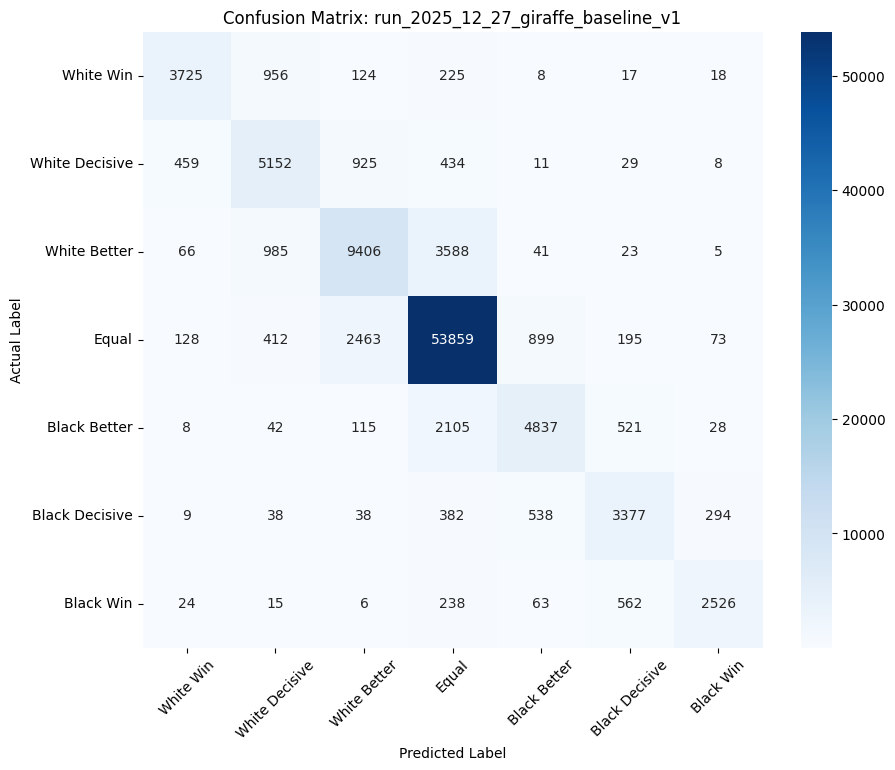

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(experiment_name: str, save_dir: str = "experiments/results"):
    matrix_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    try:
        cm = np.load(matrix_path)
    except FileNotFoundError:
        print(f"Could not find matrix at {matrix_path}")
        return

    class_names = [
        "White Win", "White Decisive", "White Better", "Equal", 
        "Black Better", "Black Decisive", "Black Win"
    ]

    plt.figure(figsize=(10, 8))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    
    plt.title(f"Confusion Matrix: {experiment_name}")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.show()

plot_confusion_matrix(RUN_ID)